# Network Construction


In [1]:
# deps
import networkx as nx
import pandas as pd
import numpy as np


In [2]:
# Read in data
edges_df = pd.read_csv("../../data/edgelists/defensemen_edgelist_corsi.csv")
players_df = pd.read_csv(
    "../../data/interim/aggregated_defensemen.csv", index_col='playerId', header=0)


In [3]:
# Construct graph from our edgelist
# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
edges_df = edges_df.rename(columns={'corsi_influence_on_player2': 'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(edges_df, 'playerId1', 'playerId2', [
                             'weight'], create_using=nx.DiGraph)

edges_df = edges_df.rename(
    columns={'weight': 'notweight', 'corsi_influence_on_player1': 'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(
    edges_df, 'playerId2', 'playerId1', edge_attr='weight', create_using=nx.DiGraph)

G = nx.compose(G0, G1)


In [4]:
# Clean up graph for community analysis
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


In [5]:
# Add data to nodes that may be useful for visualization
def copy_attr_to_nodes(G, df, attr_name):
    nodes_dict = dict.fromkeys(G.nodes)
    for node in G.nodes:
        node_attr = df.loc[[node]][attr_name].values[0]
        nodes_dict[node] = node_attr
    return nodes_dict


# Add player names to nodes
player_names = copy_attr_to_nodes(G, players_df, "playerName")
nx.set_node_attributes(G, player_names, "playerName")

# on ice corsi
player_onIce_corsis = copy_attr_to_nodes(
    G, players_df, "onIce_corsiPercentage")
nx.set_node_attributes(G, player_onIce_corsis, "onIce_corsiPercentage")

# off ice corsi
player_offIce_corsis = copy_attr_to_nodes(
    G, players_df, "offIce_corsiPercentage")
nx.set_node_attributes(G, player_offIce_corsis, "offIce_corsiPercentage")

# on/off ice corsi diff
player_corsi_diffs = copy_attr_to_nodes(G, players_df, "on_off_corsi_diff")
nx.set_node_attributes(G, player_corsi_diffs, "on_off_corsi_diff")

# on ice goals for per 60
player_gf_per60s = copy_attr_to_nodes(G, players_df, "OnIce_F_goals_per60")
nx.set_node_attributes(G, player_gf_per60s, "onIce_F_goals_per60")


# Community Analysis


In [6]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
communities = nxc.greedy_modularity_communities(G, weight='weight')
print(len(communities))

# add community info to node attributes
i = 0
communities_dict = dict.fromkeys(G.nodes)
for community in communities:
    for player in community:
        communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, communities_dict, "community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'gexf_exports/defense_positive.gexf')


24


In [7]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv(
    "../../data/final/aggregated_defensemen.csv", index_col='playerId', header=0)

# Remove players with less than 10 games to clean up playerbase data a bit
players_df_pared = players_df.drop(
    players_df[players_df.games_played < 10].index)


In [8]:
import scipy.stats as sps


def plot_distributions(stat):
    # Plot distribution of entire playerbase
    playerbase_stats = players_df_pared[stat].values
    pb_mean = np.nanmean(playerbase_stats)
    pb_dev = np.nanstd(playerbase_stats)
    print("n: ", len(playerbase_stats))
    print("mean: ", pb_mean)
    print("std dev: ", pb_dev)
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot distribution of each community individually
    i = 0
    for community in communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print("Community: ", i)
        print("n: ", len(players_stats))
        print("mean: ", np.mean(players_stats))
        print(sps.ttest_1samp(players_stats, pb_mean))
        # Reduce clutter for now
        # plt.hist(players_stats, bins)
        # plt.xlabel(stat)
        # plt.ylabel("Count")
        # title = "Community: " + str(i)
        # plt.title(title)
        # plt.show()
        i += 1


n:  608
mean:  4.997769835087394
std dev:  2.9064760138936157


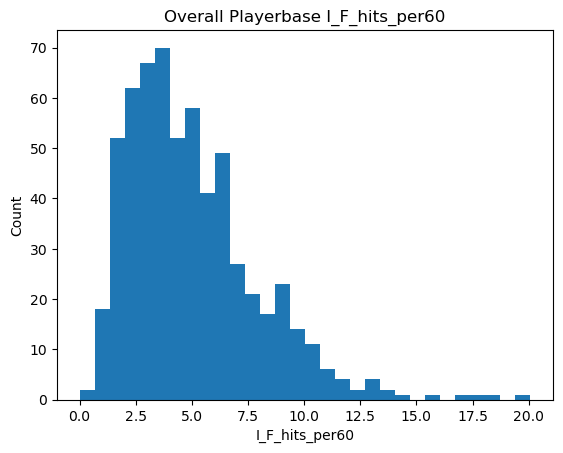

Community:  0
n:  63
mean:  5.147470455628207
Ttest_1sampResult(statistic=0.4052697856122221, pvalue=0.6866742734043133)
Community:  1
n:  53
mean:  4.335645563105952
Ttest_1sampResult(statistic=-2.1938204949985085, pvalue=0.032741243670916576)
Community:  2
n:  46
mean:  5.152098699124676
Ttest_1sampResult(statistic=0.44295958088923815, pvalue=0.6599171450524377)
Community:  3
n:  41
mean:  6.043150373851003
Ttest_1sampResult(statistic=2.825121771241933, pvalue=0.007338152473779073)
Community:  4
n:  39
mean:  4.178885485964641
Ttest_1sampResult(statistic=-2.7236460615620173, pvalue=0.009699814694087951)
Community:  5
n:  32
mean:  5.80075365450755
Ttest_1sampResult(statistic=1.3781127149461103, pvalue=0.17803505692113872)
Community:  6
n:  31
mean:  5.4747027171607785
Ttest_1sampResult(statistic=0.920841482372011, pvalue=0.36447925576907714)
Community:  7
n:  31
mean:  4.4285054326247675
Ttest_1sampResult(statistic=-1.3574108584208981, pvalue=0.18477520836308364)
Community:  8
n:  30

In [9]:
plot_distributions('I_F_hits_per60')
